# 3D analysis of X-ray Chandra data using gammapy

This notebook explores the possibility of performing a 3D (X,Y,E) analysis of X-ray data using the gammapy gamma-ray analysis tool.  
While at gamma-ray energies (due to moderate PSF), most sources can be represented by simple analitical functions (points, Gaussian, disks) this is less common in X-rays due to arcsec PSFs.  

Here we test the 3D analysis on a geometrically simple target (composite SNR IGR J14003-6326 aka SNR G310.6-1.6).  
In X-rays a nearly circular SNR shell, a PWN, and a pulsar are detected that we will model jointly.

The source is also sufficiently small (arcmin scale) to consider a flat exposure map and not having to handle CCD gaps.

Refs:
- [Discovery of a Highly Energetic Pulsar Associated with IGR J14003-6326 in the Young Uncataloged Galactic Supernova Remnant G310.6-1.6](https://ui.adsabs.harvard.edu/abs/2010ApJ...716..663R/abstract)
-[On the Expansion, Age, and Origin of the Puzzling Shell/Pulsar-wind Nebula G310.6-1.6](https://ui.adsabs.harvard.edu/abs/2019ApJ...887..233R/abstract)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u


import gammapy
gammapy.__version__

'0.19'

In [2]:

from gammapy.irf import EDispKernel,EDispKernelMap, EffectiveAreaTable2D
from gammapy.maps import WcsGeom, MapAxis, MapAxes, WcsNDMap, Map
gammapy.maps.MapAxes
from gammapy.modeling.models import PowerLawSpectralModel, TemplateNPredModel, FoVBackgroundModel
from gammapy.modeling.models.spatial import TemplateSpatialModel, GaussianSpatialModel, ShellSpatialModel, ConstantSpatialModel
from gammapy.modeling.models import SkyModel
from gammapy.modeling import Fit
from gammapy.modeling.models import SpectralModel, Parameter

from gammapy.datasets.io import OGIPDatasetReader
from gammapy.datasets import MapDataset



In [3]:
# Implementing a quick absorption to avoid loading XSpec models for this example.
# Loading sherpa Xspec models is possible and currently being tested in gammapy

class WAbsSpectralModel(SpectralModel):
    tag = "WAbsSpectralModel"
    NH = Parameter("NH", "2.1e18 cm-2", min=0)
   
    @staticmethod
    def cross_section(energy):
        edges =  [0.030,  0.100, 0.284, 0.400, 0.532, 0.707, 0.867, 1.303, 1.840, 2.471, 3.210, 4.038, 7.111, 8.331, 10, 11]*u.keV   # 1 more edge
        axis = MapAxis.from_edges(edges, name="energy_true", interp="lin")
 
        c0 = np.array([17.3, 34.6, 78.1, 71.4, 95.5, 308.9, 120.6, 141.3, 202.7, 342.7, 352.2, 433.9, 629.0, 701.2])
        c1=np.array([608.1, 267.9, 18.8, 66.8, 145.8, -380.6, 169.3, 146.8, 104.7, 18.7, 18.7, -2.4, 30.9, 25.2])
        c2=np.array([-2150., -476.1, 4.3, -51.4, -61.1, 294.0, -47.7, -31.5, -17.0, 0.0, 0,0, 0.75, 0.0, 0.0])
  
        indices = axis.coord_to_idx(energy)
        indices = np.clip(indices, 0, 13)
        
        e_no_unit = energy.to_value("keV")
        cross_section = (c0[indices] + c1[indices]*e_no_unit  + c2[indices]*e_no_unit**2)
        cross_section *= e_no_unit**-3
        cross_section = cross_section*1e-24*u.cm**2
     
        return cross_section

    @staticmethod
    def evaluate(energy, NH):
        sigma = WAbsSpectralModel.cross_section(energy) 
        return np.exp(-sigma*NH)
    
    

In [4]:
arffile='data/SNR-circle.arf'
rmffile='data/SNR-circle-ERrebin1-ET10eV.rmf'
cubefile='data/Cube_IGRJ1400_46pix_XYrebin8_Erebin16.FTZ'
bkgfile='data/blanksky_ACIS_CCD7_bkgmodel.txt'

In [5]:
cube_data=Map.read(cubefile,map_type='wcs')
cube_data.data = np.array(cube_data.data,dtype='float64')

livetime=cube_data.meta['EXPOSURE']*u.s
print(livetime)



142434.565239242 s


In [6]:
cube_data.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

## Creating a background cube
Assuming a flat spatial distribution for the blank sky.  
Should be ok here as the objetc is a few arcmins wide.

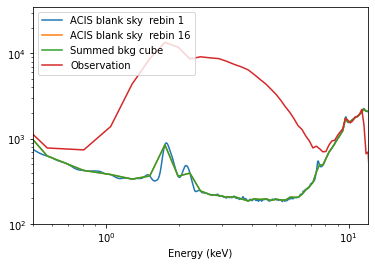

In [7]:
# Loading bkg spectrum pre-generated from Blank Sky event file produced using the `blank_sky` ciao script
Ebkg_center, bkg_model_ = np.genfromtxt('data/blanksky_ACIS_CCD7_bkgmodel.txt', unpack=True)
Ebkg_center*=u.keV

E_obs, spec_obs = cube_data.geom.axes['energy'].center, cube_data.data.sum(axis=(1,2))
bkg_model_interp=np.interp(E_obs, Ebkg_center, bkg_model_)


bkg_cube = Map.from_geom(cube_data.geom)
bkg_cube.data += 1
bkg_cube.data *= bkg_model_interp[:,None, None]/(bkg_cube.data.shape[1]*bkg_cube.data.shape[2]) #broadcast spectrum to cube



plt.plot(Ebkg_center, bkg_model_*0.55,label='ACIS blank sky  rebin 1')
plt.plot(E_obs, bkg_model_interp*0.55,label='ACIS blank sky  rebin 16')

plt.plot(E_obs,bkg_cube.data.sum(axis=(1,2))*0.55,label='Summed bkg cube')

plt.xlabel('Energy (keV)')
plt.plot(E_obs, spec_obs,label='Observation')
plt.yscale('log')
plt.ylim(1e2,)
plt.xlim(0.5,12)
plt.xscale('log')
plt.legend()
plt.show()



In [8]:
(cube_data-bkg_cube).smooth(width=1).plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

<AxesSubplot:xlabel='Energy_true [keV]', ylabel='$\\mathrm{cm^{2}\\,s}$'>

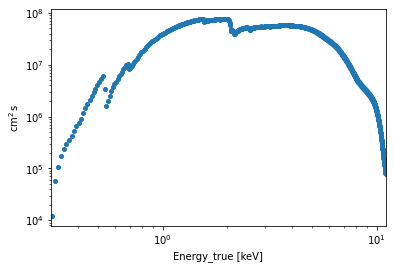

In [9]:
aeff=OGIPDatasetReader.read_arf(arffile,livetime=livetime)
aeff.plot()


In [10]:
map_geom = cube_data.geom.to_image().to_cube(axes=[aeff.geom.axes['energy_true']])
exposure = Map.from_geom(map_geom)
exposure.data += aeff.data.flatten()[:,None, None]
exposure.unit = u.cm**2 *u.s

exposure.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

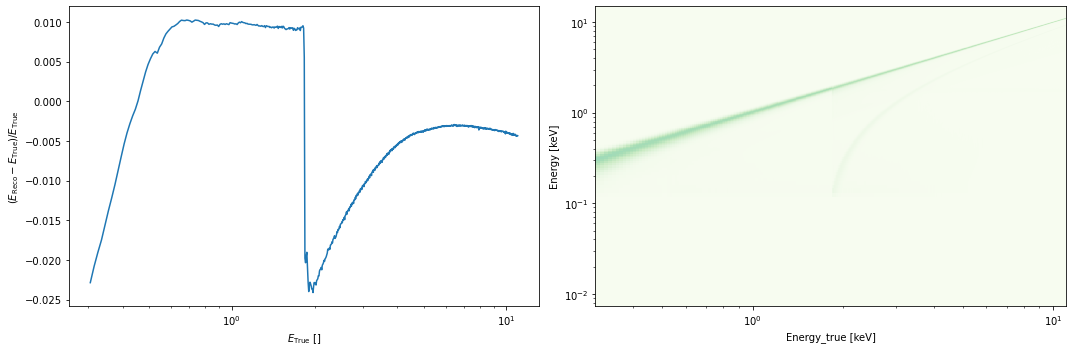

In [11]:
#Loading the standard mkacisrmf RMF (std binning)
#Trying to rebin RMF in gammapy

rmffile='data/SNR-circle-ERrebin1-ET10eV.rmf'
rmf=EDispKernel.read(rmffile)
rmf.peek()

#rmf_=rebin_array(rmf.data,1,16)
#rmf.axes['energy'].downsample(16)

# Is there a way to reshape the rmf and replace the values ?


rmf=EDispKernel.read(rmffile)
edisp=EDispKernelMap.from_edisp_kernel(rmf, geom=None)
edisp = edisp.resample_energy_axis(rmf.axes["energy"].downsample(16))
edisp.edisp_map.geom.axes['energy']
edisp

Other alternative is to just load a Gaussian RMF. Should be ok for fitting PL.

## Checking energy binning between data, exposure, edisp in E_reco and E_true

In [12]:

print('cube_data',cube_data.geom.axes['energy'])

print('edisp',edisp.edisp_map.geom.axes['energy'])
print('edisp',edisp.edisp_map.geom.axes['energy_true'])


print('exposure',exposure.geom.axes['energy_true'])

cube_data MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 64        
	node type  : edges     
	edges min  : 7.3e-03 keV
	edges max  : 1.5e+01 keV
	interp     : log       

edisp MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 64        
	node type  : edges     
	edges min  : 7.3e-03 keV
	edges max  : 1.5e+01 keV
	interp     : log       

edisp MapAxis

	name       : energy_true
	unit       : 'keV'     
	nbins      : 1070      
	node type  : edges     
	edges min  : 3.0e-01 keV
	edges max  : 1.1e+01 keV
	interp     : log       

exposure MapAxis

	name       : energy_true
	unit       : 'keV'     
	nbins      : 1070      
	node type  : edges     
	edges min  : 3.0e-01 keV
	edges max  : 1.1e+01 keV
	interp     : log       



In [13]:
# Define sky model to simulate the data

wabs=WAbsSpectralModel(NH="2.5e22 cm-2") #Value from Reynolds 2019


# Bkg model
#spatial_model = ConstantSpatialModel(value='1 sr-1')
#spectral_model = TemplateSpectralModel(Ebkg_center, bkg_model) * PowerLawNormSpectralModel(norm=10,tilt=0)
#blank_sky = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='blank_sky')
#blank_sky.parameters['value'].frozen = True
#blank_sky.parameters['norm'].frozen = False

#blank_sky = TemplateNPredModel(bkg_cube,name='blank_sky')

blank_sky = FoVBackgroundModel(dataset_name='IGRJ1400')
blank_sky.spectral_model.parameters['tilt'].frozen = False
blank_sky.spectral_model.parameters['reference'].value = 2 
blank_sky.spectral_model.parameters['reference'].unit = u.keV


#PWN model
image=Map.read('data/Cube_IGRJ1400_46pix_XYrebin8_Erebin16_comp0.fits',map_type='wcs')
image.data[image.data<30] = 0

spatial_model = TemplateSpatialModel(image)
spectral_model = wabs*PowerLawSpectralModel(index=1.9, amplitude="2e-3 cm-2 s-1 keV-1", reference="2 keV")
pwn = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='pwn')

pwn.parameters['index'].min = 1
pwn.parameters['index'].max = 5
pwn.parameters['reference'].value = 2


# Shell model
spatial_model = ShellSpatialModel(lon_0=210.1891*u.deg,lat_0= -63.4287*u.deg,radius=68.57*u.arcsec,width=13*u.arcsec,frame='icrs')
spectral_model = wabs*PowerLawSpectralModel(index=2.3, amplitude="6.e-4 cm-2 s-1 keV-1", reference="2 keV")
shell = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='shell')

shell.parameters['reference'].value = 2
shell.parameters['radius'].min = 65
shell.parameters['radius'].max = 75
shell.parameters['width'].min = 1
shell.parameters['width'].max = 25

shell.parameters['lon_0'].frozen = True
shell.parameters['lat_0'].frozen = True
shell.parameters['radius'].frozen = True
shell.parameters['width'].frozen = True


#shell.spectral_model.NH =  pwn.spectral_model.NH
#shell.spectral_model.parameters['NH']=pwn.spectral_model.parameters['NH']

# PSR model
spatial_model = GaussianSpatialModel(lon_0=210.1905*u.deg, lat_0=-63.4283*u.deg,sigma=0.5*u.arcsec,frame='icrs')
spectral_model = wabs*PowerLawSpectralModel(index=1.5, amplitude="4.e-4 cm-2 s-1 keV-1", reference="2 keV")
psr = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='psr')

psr.parameters['reference'].value = 2
psr.parameters['lon_0'].frozen = True
psr.parameters['lat_0'].frozen = True
psr.parameters['sigma'].frozen = True



shell.parameters["NH"].frozen = True
sky_model =  (shell + pwn + psr) + blank_sky
print(sky_model)


#for n in sky_model.names:
#    sky_model[n].spectral_model.plot(energy_bounds=[1, 11] * u.keV, n_points=1000)

Models

Component 0: SkyModel

  Name                      : shell
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ShellSpatialModel
  Temporal model type       : 
  Parameters:
    NH           (frozen)   : 24999999999999997902848.000      1 / cm2     
    index                   :      2.300   +/-    0.00             
    amplitude               :   6.00e-04   +/- 0.0e+00 1 / (cm2 keV s)
    reference    (frozen)   :      2.000       keV         
    lon_0        (frozen)   :    210.189       deg         
    lat_0        (frozen)   :    -63.429       deg         
    radius       (frozen)   :     68.570       arcsec      
    width        (frozen)   :     13.000       arcsec      

Component 1: SkyModel

  Name                      : pwn
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameter

In [14]:
mask = Map.from_geom(cube_data.geom)
mask.data = False 
E1, E2 = 1*u.keV, 11*u.keV
i1,i2 =cube_data.geom.axes[0].coord_to_idx([E1,E2])
mask.data[i1:i2,:,:] = True

mask.plot_interactive(add_cbar=True)


interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [15]:
dataset = MapDataset(
    models=sky_model,
    counts=cube_data,
    exposure=exposure,
    edisp=edisp,
    psf=None,
    mask_fit=mask,
    background=bkg_cube,
    name='IGRJ1400'
)


In [16]:
%time
print((dataset.npred().data*mask).sum(), (cube_data.data*mask).sum() )
#This seems too fast, probably Npred is cached somewhere.

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs
243233.32471118105 159649.0


In [17]:
%time
dataset.reset_data_cache
dataset.npred().data.sum()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.91 µs


315938.6707161526

In [18]:
dataset.npred().plot_interactive(add_cbar=True,vmin=0,cmap='CMRmap_r')


interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

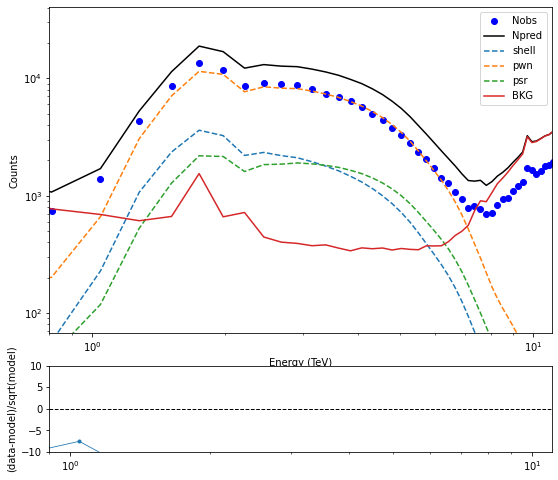

In [19]:
#%%time 
# Plot 1st guess
def plot_data_model(dataset,comp=True):
    spec_signal=dataset.npred_signal().data.sum(axis=(1,2))
    spec_obs=dataset.counts.data.sum(axis=(1,2))
    spec_bkg=dataset.npred_background().data.sum(axis=(1,2))
    spec_npred=spec_signal+spec_bkg

    e=dataset.counts.geom.axes[0].center

    
    spec_resid=(spec_obs-spec_npred)/np.sqrt(spec_npred)


    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))   

    L=0.125
    #ax1=fig.add_axes((L,0.5,0.775,.4))
    ax1.loglog(e,spec_obs,color='blue',label='Nobs',marker='o',ls='None')
    ax1.loglog(e,spec_npred,color='black',label='Npred')
    if comp:
        for i,mod in enumerate(dataset.models):
            if type(mod) == SkyModel:
                dataset_ = MapDataset(
                    models=mod,
                    counts=dataset.counts,
                    exposure=dataset.exposure,
                    edisp=dataset.edisp,
                    mask_safe=mask)

                npred_comp = dataset_.npred()
                spec_npred_comp = npred_comp.data.sum(axis=(1,2))
                ax1.loglog(e,spec_npred_comp,ls='--',label=mod.name)
    ax1.loglog(e,spec_bkg,label='BKG')
    ax1.set_xlabel('Energy (TeV)')
    ax1.set_ylabel('Counts')
    ax1.set_ylim(spec_obs.max()*5e-3, spec_obs.max()*3)
    ax1.set_xlim(0.8,11)
    plt.legend()


    ax2=fig.add_axes((L,-.15,0.775,.2))


    ax2.plot(e,spec_resid,
                 marker='.',lw=0.8,label='residuals')

    ax2.set_xscale('log')    
    ax2.axhline(0, color='k', lw=1, ls='--')
    ax2.set_ylabel('(data-model)/sqrt(model)')
    ax2.set_xlim(0.9,11)
    ax2.set_ylim(-10,10)

        
plot_data_model(dataset, comp=True)    

In [20]:
%%time
fit = Fit(optimize_opts={"print_level": 2})
result = fit.optimize(datasets=[dataset])

I MnSeedGenerator Initial state: FCN =      -563457.6395 Edm =       80415.34773 NCalls =     37
I VariableMetricBuilder Start iterating until Edm is < 0.0002 with call limit = 1320
I VariableMetricBuilder    0 - FCN =      -563457.6395 Edm =       80415.34773 NCalls =     37
I VariableMetricBuilder    1 - FCN =      -571082.4538 Edm =        64603.7358 NCalls =     59
I VariableMetricBuilder    2 - FCN =      -598824.0586 Edm =       2857.989559 NCalls =     84
I VariableMetricBuilder    3 - FCN =       -599822.253 Edm =       331.2497158 NCalls =    102
I VariableMetricBuilder    4 - FCN =      -600063.9414 Edm =        140.192518 NCalls =    120
I VariableMetricBuilder    5 - FCN =      -600440.2059 Edm =       305.1329013 NCalls =    139
I VariableMetricBuilder    6 - FCN =      -600852.2028 Edm =       55.17802538 NCalls =    158
I VariableMetricBuilder    7 - FCN =      -601005.8247 Edm =       70.34094873 NCalls =    176
I VariableMetricBuilder    8 - FCN =      -601091.8893 Edm

In [21]:
#Know issue about covariance matrix size 
#Fixed in PR https://github.com/gammapy/gammapy/pull/3687

from gammapy.modeling import Covariance
# set covariance independently 
sky_model.covariance = Covariance.from_factor_matrix(
    parameters=sky_model.parameters,
    matrix=fit.minuit.covariance
)

In [22]:
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : shell
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ShellSpatialModel
  Temporal model type       : 
  Parameters:
    NH           (frozen)   : 24999999999999997902848.000      1 / cm2     
    index                   :      2.440   +/-    0.02             
    amplitude               :   3.41e-04   +/- 4.3e-06 1 / (cm2 keV s)
    reference    (frozen)   :      2.000       keV         
    lon_0        (frozen)   :    210.189       deg         
    lat_0        (frozen)   :    -63.429       deg         
    radius       (frozen)   :     68.570       arcsec      
    width        (frozen)   :     13.000       arcsec      

Component 1: SkyModel

  Name                      : pwn
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Pa

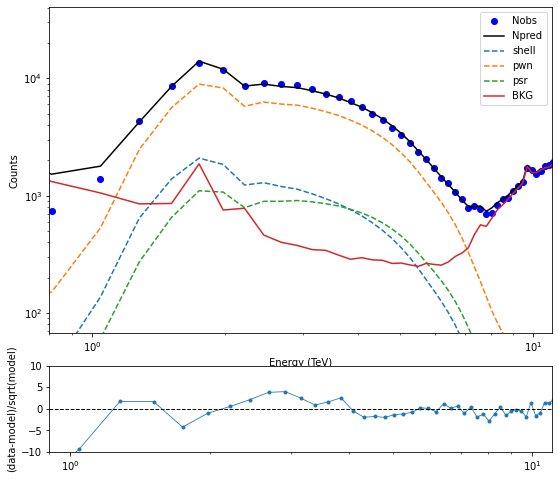

In [23]:
plot_data_model(dataset, comp=True)

## Looking at the residual map

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

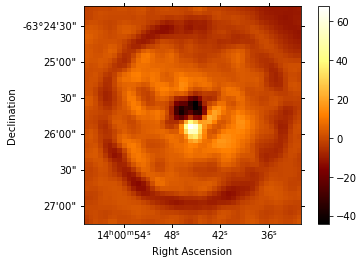

In [24]:
dataset.residuals(method="diff").sum_over_axes().smooth(width=1).plot(add_cbar=True)

## Residuals around 50, not so bad compared to thousands counts in original data

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

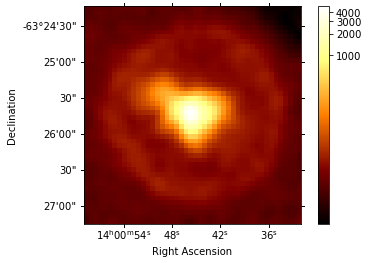

In [25]:
(cube_data*mask).sum_over_axes().smooth(width=1).plot(add_cbar=True,stretch='log')

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

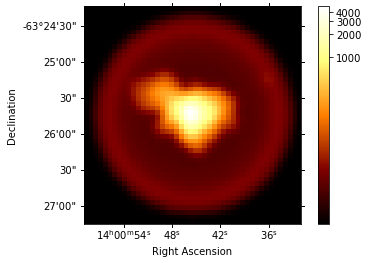

In [26]:
dataset.npred().sum_over_axes().smooth(width=1).plot(add_cbar=True,stretch='log')

In [27]:
dataset.npred().plot_interactive(add_cbar=True,cmap='CMRmap_r',vmin=0)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [28]:
dataset.residuals(method="diff").smooth(width=1.5).plot_interactive(add_cbar=True,cmap='jet')

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

# Creating BKG model from blanksky event file

Event file is produced using the ciao `blanksky` script  ([link](https://cxc.harvard.edu/ciao/ahelp/blanksky.html)).

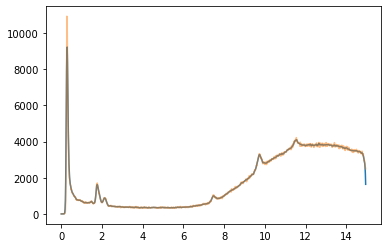

In [29]:

from astropy.convolution import Gaussian1DKernel, convolve
import astropy.table as table

rmf = EDispKernel.read(rmffile)


bkg_evtfile = '/Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/data/IGRJ1400/19919/primary/blanksky_CCD7_evt.fits'

evt = table.Table.read(bkg_evtfile)
counts = np.histogram(evt['energy'].to('keV'),bins=rmf.axes['energy'].edges)[0]

kernel = Gaussian1DKernel(stddev=1.5)
bkg_model = convolve(counts,kernel)

plt.plot(rmf.axes['energy'].center,bkg_model )
plt.plot(rmf.axes['energy'].center,counts,alpha=0.5 )


np.savetxt('blanksky_ACIS_CCD7_bkgmodel.txt', np.array([rmf.axes['energy'].center.value,bkg_model]).T,fmt='%.4f' )



## mkacisrmf cannot provide rmf binned in Energy reco
Issue mentionned in BUG section of mkacisrmf :  
https://cxc.harvard.edu/ciao/ahelp/mkacisrmf.html

Should maybe interpolate in gammapy.



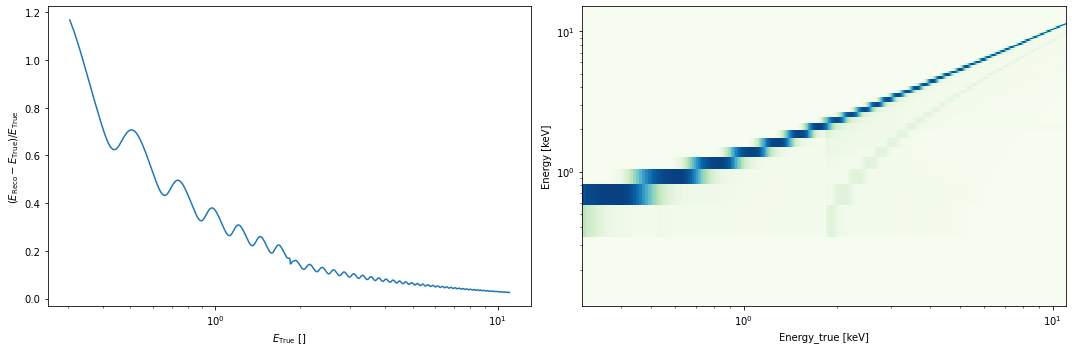

In [30]:
rmffile='data/SNR-circle-ERrebin16-ET10eV.rmf'
rmf=EDispKernel.read(rmffile)
rmf.peek()
